In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim

In [3]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
class Puasson1DPINN(nn.Module):
    def __init__(self, layers):
        super(Puasson1DPINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.hidden_layers.append(nn.Linear(layers[i-1], layers[i]))

    def forward(self, x_t):
        for layer in self.hidden_layers[:-1]:
            x_t = torch.tanh(layer(x_t))
        x_t = self.hidden_layers[-1](x_t)
        return x_t
    
    def compute_gradients(self, x_t):
        x_t.requires_grad = True

        u = self.forward(x_t)

        u_x = torch.autograd.grad(outputs=u, inputs=x_t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0][:, 0]
        u_xx = torch.autograd.grad(outputs=u_x, inputs=x_t, grad_outputs=torch.ones_like(u_x), create_graph=True, allow_unused=True)[0][:, 0]
        u_t = torch.autograd.grad(outputs=u, inputs=x_t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0][:, 1]
        return u, u_x, u_xx, u_t

    def dirichlet_conditions(self, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom):
        u_top, _, _, _ = self.compute_gradients(x_t_bc_top)
        u_bottom, _, _, _ = self.compute_gradients(x_t_bc_bottom)
        return torch.mean((u_top - u_bc_top) ** 2) + torch.mean((u_bottom - u_bc_bottom) ** 2)
    
    def neuman_conditions(self, x_t_bc_left_1D, x_t_bc_right_1D, alpha):
        u_left, u_x_left, _, u_t_left = self.compute_gradients(x_t_bc_left_1D)
        u_right, u_x_right, _, u_t_right = self.compute_gradients(x_t_bc_right_1D)
        return torch.mean((-u_x_left - alpha * u_left) ** 2) + torch.mean((u_x_right - 0) ** 2)

    def loss_fn(self, x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha):
        u, u_x, u_xx, u_t = self.compute_gradients(x_t_train)
        # Placeholder for Poisson equation and f(x_t_train), adjust as per your actual computation
        heat_eq = u_t - a * u_xx - self.f(x_t_train)  # This is a placeholder equation
        bc_dirichlet_loss = self.dirichlet_conditions(x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom)
        bc_neuman_loss = self.neuman_conditions(x_t_bc_left_1D, x_t_bc_right_1D, alpha)
        return torch.mean(heat_eq**2) + 10 * bc_dirichlet_loss + bc_neuman_loss
    
    def f(self, x_t):
        x, t = x_t[:, 0], x_t[:, 1]
        return 0

 ∂u/∂t = a * ∂^2u/∂x^2
 
                                       u = 1
                             __________________________
                             ||                       ||
∂u/∂n = -∂u/∂x = alpha * u   || t                     || ∂u/∂n = ∂u/∂x = 0
                             ||          x            ||
                             ||_______________________||
                                       u = 0

In [5]:
def train(model, optimizer, loss_threshold, x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha):
    model.train()  # Set the model to training mode (affects certain modules like Dropout, BatchNorm, etc.)
    optimizer.zero_grad()
    loss = model.loss_fn(x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha)
    loss_array = []
    epoch = 0
    start_time = time.time()
    try:
        while loss.item() > loss_threshold:
            optimizer.zero_grad()  # Clears old gradients from the last step (otherwise gradients would accumulate)
            
            # Compute the loss based on the provided training and boundary condition data
            loss = model.loss_fn(x_t_train, x_t_bc_top, x_t_bc_bottom, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha)
            
            loss.backward()  # Backpropagate the loss to compute gradients
            optimizer.step()  # Adjust model parameters based on the computed gradients

            loss_array.append(loss.item())
            if epoch % 100 == 0:  # Optionally print the loss every 100 epochs
                print(f'Epoch {epoch}, Loss: {loss.item()}')

            epoch += 1
    except KeyboardInterrupt:
        print("Training stopped manually")
            
    print("Training took %s seconds" % (time.time() - start_time))
    print(f"Last epoch: {epoch}, loss: {loss.item()}")

    plt.plot(loss_array)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.title('Mean loss during training')
    plt.show(block=False)


In [6]:
layers = [2, 20, 20, 20, 1]  # Adjusted first layer to accept 2 inputs (x and t)
model = HeatPINN(layers)
optimizer = optim.AdamW(model.parameters(), lr=1e-03)

In [7]:
# Example Data Preparation (Adapt this to your actual data)
a = 1 # coefficient in equation
alpha = 1
N_train_x = 100
N_train_t = 100
N_test_x = 100
N_test_t = 100
N_bc = 100
L_x, R_x = 0.0, 1.0
L_t, R_t = 0.0, 1.0

x_train = np.linspace(L_x, R_x, N_train_x)
t_train = np.linspace(L_t, R_t, N_train_t)
X_train, T_train = np.meshgrid(x_train, t_train)
x_t_train = np.hstack((X_train.flatten()[:, None], T_train.flatten()[:, None]))
x_t_train = torch.tensor(x_t_train, dtype=torch.float32)

x_bc = np.linspace(L_x, R_x, N_bc)
x_t_bc_top = np.hstack((x_bc[:, None], R_t * np.ones_like(x_bc)[:, None]))
x_t_bc_bottom = np.hstack((x_bc[:, None], L_t * np.ones_like(x_bc)[:, None]))
x_t_bc_top_1D = torch.tensor(x_t_bc_top, dtype=torch.float32)
x_t_bc_bottom_1D = torch.tensor(x_t_bc_bottom, dtype=torch.float32)

# Example u values for Dirichlet conditions, replace with actual functions f(t) and g(t)
u_bc_top = torch.ones(len(x_bc), 1)  # u = 1 at the top boundary
u_bc_bottom = torch.zeros(len(x_bc), 1)  # u = 0 at the bottom boundary

# Combine the top and bottom boundary conditions into one tensor
u_bc_top_bottom_1D = torch.cat([u_bc_bottom, u_bc_top], dim=0)

t_bc = np.linspace(L_t, R_t, N_bc)
x_t_bc_left = np.hstack((L_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_right = np.hstack((R_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_left_1D = torch.tensor(x_t_bc_left, dtype=torch.float32)
x_t_bc_right_1D = torch.tensor(x_t_bc_right, dtype=torch.float32)



Epoch 0, Loss: 13.159709930419922
Epoch 100, Loss: 0.4502395987510681
Epoch 200, Loss: 0.3651895225048065
Epoch 300, Loss: 0.31080761551856995
Epoch 400, Loss: 0.2805142104625702
Epoch 500, Loss: 0.26843929290771484
Epoch 600, Loss: 0.26375436782836914
Epoch 700, Loss: 0.26043376326560974
Epoch 800, Loss: 0.2574445605278015
Epoch 900, Loss: 0.25470995903015137
Epoch 1000, Loss: 0.252216637134552
Epoch 1100, Loss: 0.24995587766170502
Epoch 1200, Loss: 0.24791836738586426
Epoch 1300, Loss: 0.24609056115150452
Epoch 1400, Loss: 0.24445368349552155
Epoch 1500, Loss: 0.2429870218038559
Epoch 1600, Loss: 0.24167177081108093
Epoch 1700, Loss: 0.24049311876296997
Epoch 1800, Loss: 0.23943962156772614
Epoch 1900, Loss: 0.23849980533123016
Epoch 2000, Loss: 0.23765802383422852
Epoch 2100, Loss: 0.23689338564872742
Epoch 2200, Loss: 0.2361822873353958
Epoch 2300, Loss: 0.23550254106521606
Epoch 2400, Loss: 0.23483505845069885
Epoch 2500, Loss: 0.23416170477867126
Epoch 2600, Loss: 0.2334603965282

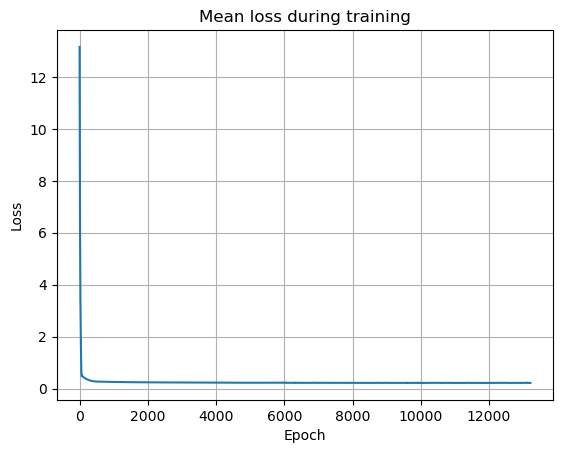

In [8]:
# Training the model
train(model, optimizer, 0.06, x_t_train, x_t_bc_top_1D, x_t_bc_bottom_1D, u_bc_top, u_bc_bottom, x_t_bc_left_1D, x_t_bc_right_1D, a, alpha)

Test 1:
    Lambda_1 = 10
    Lambda_2 = 1
    Time = 80m
    loss = 0.034
    MSE with MCE = 3.85%
Test 2:
    

In [9]:
def calculate_max_relative_error(u_pred, u_exact):
    max_diff_index = np.argmax(u_exact - u_pred)
    print("Max difference index:", max_diff_index)
    difference = u_exact - u_pred
    # Find the flattened index of the maximum difference
    max_diff_index_flattened = np.argmax(np.abs(difference))

    # Convert the flattened index to 2D row and column indices
    max_diff_row, max_diff_col = np.unravel_index(max_diff_index_flattened, difference.shape)
    print(f"Row: {max_diff_row}, column: {max_diff_col}")

    # Display the maximum difference
    print("Max difference:", np.abs(difference[max_diff_row, max_diff_col]))

    # Display the elements from both arrays corresponding to the maximum difference
    print("Element from u_exact with max difference:", u_exact[max_diff_row, max_diff_col])
    print("Element from u_pred with max difference:", u_pred[max_diff_row, max_diff_col])
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

In [10]:
x_test = np.linspace(L_x, R_x, N_test_x)
t_test = np.linspace(L_t, R_t, N_test_t)
X_test, T_test = np.meshgrid(x_test, t_test)
x_t_test = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
x_t_test_tensor = torch.tensor(x_t_test, dtype=torch.float32)

# Evaluate the model on these points
model.eval()  # Set the model to evaluation mode
u_pred = model(x_t_test_tensor).detach().cpu().numpy()

# Reshape u_pred to match the grid shape
U_pred = u_pred.reshape(X_test.shape)

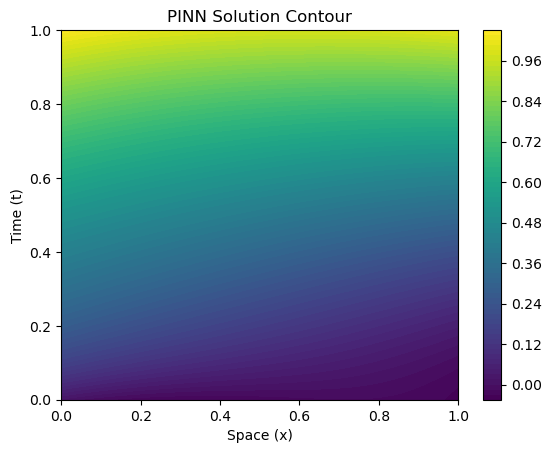

In [11]:
plt.contourf(X_test, T_test, U_pred, levels=100, cmap='viridis')
plt.colorbar()
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('PINN Solution Contour')
plt.show()

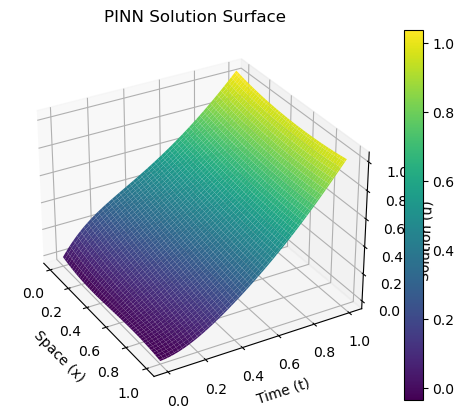

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_test, T_test, U_pred, cmap='viridis', edgecolor='none')
fig.colorbar(surf)
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Solution (u)')
ax.set_title('PINN Solution Surface')
ax.view_init(elev=30, azim=-30)
plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem

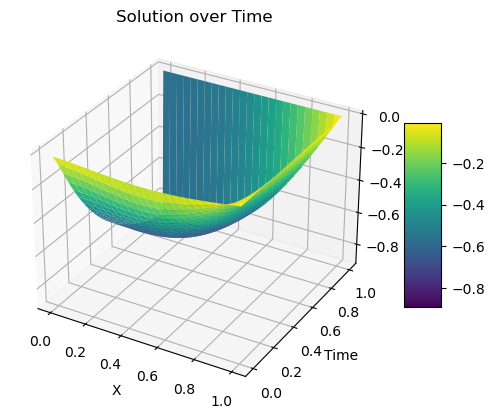

In [24]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
T = 1.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size
a = 1.0            # diffusion coefficient

# Create mesh for a 1D domain
mesh = IntervalMesh(50, 0, 1)  # More divisions for smoother spatial resolution

# Define function space for a scalar (P1) function
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition at x=1 (right boundary, Dirichlet)
bc_right = DirichletBC(V, Constant(0), 'near(x[0], 1)')

# Initial condition
u_n = interpolate(Constant(0), V)  # assuming initial condition is u=0 everywhere

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('-pi*sin(pi*x[0])', degree=2)

F = u*v*dx + dt*a*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Prepare data for surf plot
x = np.linspace(0, 1, 51)  # Spatial points
timesteps = np.linspace(0, T, num_steps+1)  # Time points
X, Timesteps = np.meshgrid(x, timesteps)  # Create meshgrid for X, T
U = np.zeros_like(X)  # Solution array

# Time-stepping
u = Function(V)
for n in range(num_steps):
    solve(a == L, u, bc_right)
    u_n.assign(u)

    # Store solution values
    U[n, :] = np.array([u(point) for point in x])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Timesteps, U, cmap='viridis')

# Final plot adjustments
ax.set_xlabel('X')
ax.set_ylabel('Time')
ax.set_zlabel('U')
ax.set_title('Solution over Time')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add a color bar to indicate the U values
plt.show()


Solving useing FEM
Solving linear variational problem.


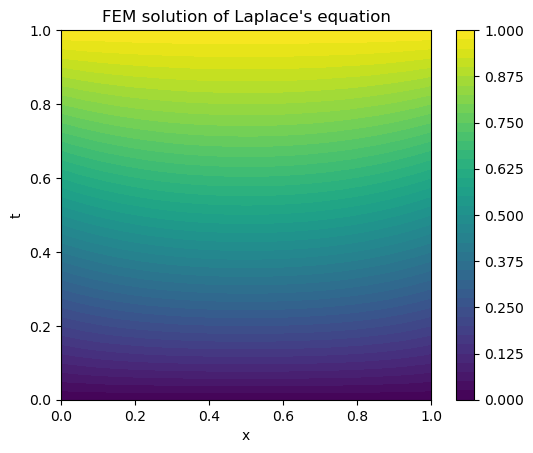

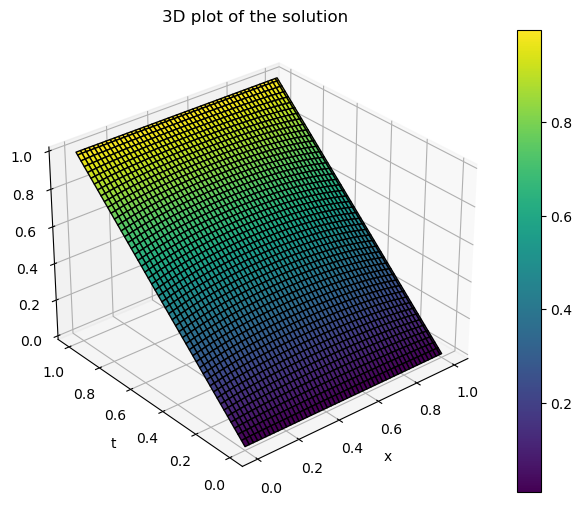

Mean Squared Error (PINN and FEM): 0.01359346169860859
Max difference index: 1700
Row: 50, column: 78
Max difference: 0.1969725593663605
Element from u_exact with max difference: 0.35963076
Element from u_pred with max difference: 0.5566033228970917
Relative error (PINN and FEM): 14.40%


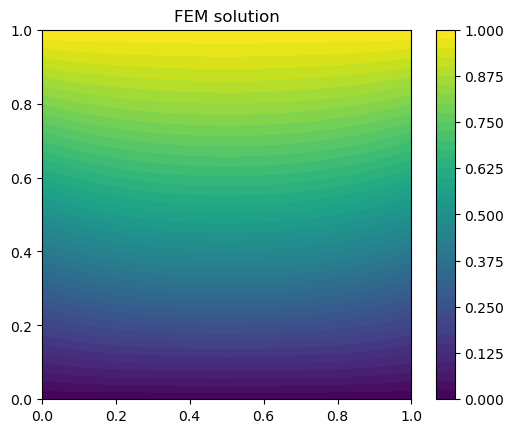

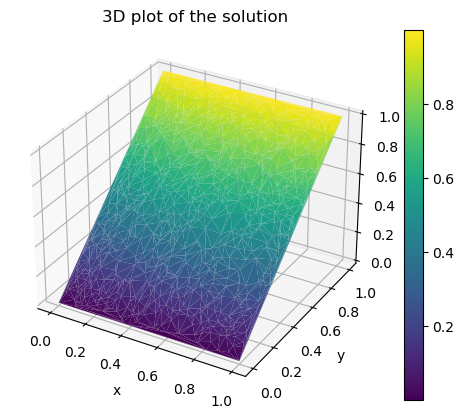

In [19]:
print("Solving useing FEM")

import numpy as np
from scipy.spatial import Delaunay

n_interior_points = 1000  # Number of interior points to generate
interior_points = np.random.rand(n_interior_points, 2)
x_max = y_max = 1
x_min = y_min = 0

corners = np.array([
    [x_min, y_min],  # Bottom left corner
    [x_max, y_min],  # Bottom right corner
    [x_max, y_max],  # Top right corner
    [x_min, y_max]   # Top left corner
])

interior_points[:, 0] = interior_points[:, 0] * (x_max - x_min) + x_min
interior_points[:, 1] = interior_points[:, 1] * (y_max - y_min) + y_min
points = np.vstack([corners, interior_points])
tri = Delaunay(points)

from fenics import *
import matplotlib.pyplot as plt
import numpy as np

mesh = Mesh()
editor = MeshEditor()
editor.open(mesh, "triangle", 2, 2)
editor.init_vertices(len(points))
for i, vertex in enumerate(points):
    editor.add_vertex(i, vertex)
editor.init_cells(len(tri.simplices))
for i, simplex in enumerate(tri.simplices):
    editor.add_cell(i, simplex)
editor.close()

V = FunctionSpace(mesh, 'P', 1)
n = FacetNormal(mesh)

# Define boundary conditions
def boundary_upper(x, on_boundary):
    return on_boundary and near(x[1], R_x)

def boundary_lower(x, on_boundary):
    return on_boundary and near(x[1], L_x)

bc_upper = DirichletBC(V, Constant(1), boundary_upper)
bc_lower = DirichletBC(V, Constant(0), boundary_lower)

# Define Robin condition on the left boundary
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0)

# Initialize mesh function for boundary domains
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
left_boundary = LeftBoundary()
left_boundary.mark(boundaries, 1)

# Define measure for integrating over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

bcs = [bc_upper, bc_lower]

# Define problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1)  # Assuming a source term
g = Constant(0)  # Assuming g on the Robin boundary is 0 for simplicity
alpha_c = Constant(alpha)
a_C = Constant(a)
left_side = a_C*dot(grad(u), grad(v))*dx + alpha_c*u*v*ds(1) + dot(grad(u), n)*v*ds(1)
right_side = f*v*dx + g*v*ds(1)

# Compute solution
u_fenics_app = Function(V)
solve(left_side == right_side, u_fenics_app, bcs)


# Plot solution using matplotlib
c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution of Laplace's equation")
plt.xlabel('x')
plt.ylabel('t')
plt.savefig('fenics_solution_half_dirichlet_Laplace_heatmap.png')
plt.show()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(L_x, R_x, N_test_x)
t = np.linspace(L_t, R_t, N_test_t)
X, T = np.meshgrid(x, t)
points = np.vstack((X.ravel(), T.ravel())).T

# Initialize an array to store the solution
u_fenics = np.zeros_like(points[:, 0])

# Evaluate the FEniCS solution at each point
for i, point in enumerate(points):
    u_fenics[i] = u_fenics_app(point)

# Reshape the solution to a 2D grid for plotting or comparison
u_fenics_grid = u_fenics.reshape((len(x), len(t)))

surf = ax.plot_surface(X, T, u_fenics_grid, cmap='viridis', edgecolor='k')
plt.colorbar(surf)
plt.title("3D plot of the solution")
plt.xlabel('x')
plt.ylabel('t')
ax.set_zlabel('u')
plt.savefig('fenics_solution_half_dirichlet_Laplace_3D.png')
ax.view_init(elev=30, azim=-130)
plt.show()

print("Mean Squared Error (PINN and FEM):", np.mean((u_fenics_grid - U_pred)**2))

relative_error = calculate_max_relative_error(u_fenics_grid, U_pred)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")


c = plot(u_fenics_app)
plt.colorbar(c)
plt.title("FEM solution")
plt.show()

# Evaluate solution at mesh vertices for 3D plotting
x = mesh.coordinates()[:, 0]
y = mesh.coordinates()[:, 1]
u_fenics = np.array([u_fenics_app(point) for point in mesh.coordinates()])

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, u_fenics, cmap='viridis', edgecolor='none')
plt.colorbar(surf)
plt.title("3D plot of the solution")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()